In [83]:
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# タイトルとカテゴリーのデータセットを読み込み
import pickle
import pandas as pd
drive_dir = "drive/My Drive/Colab Notebooks/livedoor_data/"

with open(drive_dir + "livedoor_title_category.pickle", 'rb') as f:
  livedoor_data = pickle.load(f)

livedoor_data.head()

,title,category
0,海外でも快適インターネット！KDDI、「au Wi-Fi SPOT」のサービスを拡充,it-life-hack
1,【特集/JOURNEY】 刺激的で優しいアラブの国へ （4/8）,livedoor-homme
2,独女のTwitter、意外な楽しみ方,dokujo-tsushin
3,ピラミッドが20年でつくられたという話は嘘,movie-enter
4,剛力彩芽、“愛情たっぷり”の手作りチョコケーキをプレゼント,movie-enter


In [88]:
# カテゴリーのリストをデータセットから取得
categories = list(set(livedoor_data['category']))
print(categories)

# カテゴリーのID辞書を作成
id2cat = dict(zip(list(range(len(categories))), categories))
cat2id = dict(zip(categories, list(range(len(categories)))))
print(id2cat)
print(cat2id)

# DataFrameにカテゴリーID列を追加
livedoor_data['category_id'] = livedoor_data['category'].map(cat2id)

# 念の為シャッフル
livedoor_data = livedoor_data.sample(frac=1).reset_index(drop=True)

livedoor_data = livedoor_data[['title', 'category_id']]
livedoor_data.head()

['topic-news', 'movie-enter', 'livedoor-homme', 'it-life-hack', 'dokujo-tsushin', 'sports-watch', 'kaden-channel', 'peachy', 'smax']
{0: 'topic-news', 1: 'movie-enter', 2: 'livedoor-homme', 3: 'it-life-hack', 4: 'dokujo-tsushin', 5: 'sports-watch', 6: 'kaden-channel', 7: 'peachy', 8: 'smax'}
{'topic-news': 0, 'movie-enter': 1, 'livedoor-homme': 2, 'it-life-hack': 3, 'dokujo-tsushin': 4, 'sports-watch': 5, 'kaden-channel': 6, 'peachy': 7, 'smax': 8}


,title,category_id
0,ナイナイ岡村、AKB特番の出演依頼を拒否 「ああいうところに出るのは……」,0
1,C-3POが名場面を紹介する『スター・ウォーズinコンサート』日本上陸,1
2,盗撮現場を配信!? 無料イベント中継のはずが衝撃的瞬間が発覚【話題】,6
3,「相棒最終回で及川光博へ“非情な仕打ち”」と女性自身,0
4,長谷部やカズよりも上？ 「小学生が好きなスポーツ選手」に意外な選手が,5


In [89]:
# 学習用データとテストデータに分ける
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(livedoor_data, train_size=0.8)
print("学習データサイズ", train_df.shape[0])
print("テストデータサイズ", test_df.shape[0])

# tsvファイルとして保存する
train_df.to_csv(drive_dir + 'train.tsv', sep='\t', index=False, header=None)
test_df.to_csv(drive_dir + 'test.tsv', sep='\t', index=False, header=None)

学習データサイズ 5900
テストデータサイズ 1476


In [90]:
# MeCabとtransformersを用意する
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
# 以下で報告があるようにmecab-python3のバージョンを0.996.5にしないとtokezerで落ちる
# https://stackoverflow.com/questions/62860717/huggingface-for-japanese-tokenizer
!pip install mecab-python3==0.996.5
!pip install unidic-lite # これないとMeCab実行時にエラーで落ちる
!pip install transformers

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.7)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.9)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already install

In [91]:
import torch
import torchtext
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer

# 日本語BERTの分かち書き用tokenizerを宣言
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# 試しに分かち書きしてみる。
text = list(train_df['title'])[0]
wakati_ids = tokenizer.encode(text, return_tensors='pt')
print(tokenizer.convert_ids_to_tokens(wakati_ids[0].tolist()))
print(wakati_ids, wakati_ids.size())

['[CLS]', '身長', 'が', '低い', '女性', 'は', '結婚', 'に', '不利', '?', '[SEP]']
tensor([[   2, 7236,   14, 3458,  969,    9, 1519,    7, 9839, 2935,    3]]) torch.Size([1, 11])


76


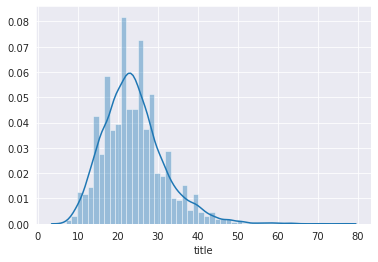

In [93]:
# 日本語BERTで扱える文章の長さ（分かち書きの数）は512だけど、livedoorニュースのタイトルの長さは最大でもCLS, SEPトークン入れても76
import seaborn as sns
# sns.set_style('darkgrid')
title_length = livedoor_data['title'].map(tokenizer.encode).map(len)
print(max(title_length))
sns.distplot(title_length)

In [20]:
# torchtextを使って、学習データとテストデータのイテレータを作成
def bert_tokenizer(text):
  return tokenizer.encode(text, return_tensors='pt')[0]

TEXT = torchtext.data.Field(sequential=True, tokenize=bert_tokenizer, use_vocab=False, lower=False,
                            include_lengths=True, batch_first=True, pad_token=0)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

train_data, test_data = torchtext.data.TabularDataset.splits(
    path=drive_dir, train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label', LABEL)])

# BERTではミニバッチサイズは16か32を使うようですが、livedoorタイトルは文章の長さが短いので32を使用してみる
BATCH_SIZE = 32
train_iter, test_iter = torchtext.data.Iterator.splits((train_data, test_data), batch_sizes=(BATCH_SIZE, BATCH_SIZE), repeat=False, sort=False)

In [46]:
item = next(iter(train_data))
print(item.Text)
print("長さ：", len(item.Text))  # 長さを確認 [CLS]から始まり[SEP]で終わる。512より長いと後ろが切れる
print("ラベル：", item.Label)

print(tokenizer.convert_ids_to_tokens(item.Text.tolist()))  # 文章
id2cat[int(item.Label)] 

batch = next(iter(train_iter))
print(batch)
print(batch.Text[0].shape)
print(batch.Label.shape)

tensor([    2,  4492, 28449,   900,     7,  2935,  1793,    51,     7,  2935,
         7731,  3276,  7334,    13,     5,  1295,    28,   707, 12018,  1975,
            5,    73,    55, 28466, 28542,   666,   253,  9680,  4459,  9594,
            3])
長さ： 31
ラベル： 8
['[CLS]', '寝', '##る', 'とき', 'に', '?', '移動', '中', 'に', '?', '実は', '使い', 'にくい', 'と', 'の', '声', 'も', '多い', 'iP', '##ad', 'の', 'お', 'ス', '##ス', '##メ', '利用', '法', '【', '話題', '】', '[SEP]']

[torchtext.data.batch.Batch of size 32]
	[.Text]:('[torch.LongTensor of size 32x40]', '[torch.LongTensor of size 32]')
	[.Label]:[torch.LongTensor of size 32]
torch.Size([32, 40])
torch.Size([32])


In [99]:
# BERT modelの使い方確認
# Referenceはこちら
# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
from transformers.modeling_bert import BertModel
model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
batch = next(iter(test_iter))
print(batch.Text[0].size())
last_hidden_state, pooler_output, attentions = model(batch.Text[0], output_attentions=True)
print(last_hidden_state.size())
print(pooler_output.size())
print(len(attentions), attentions[-1].size())

torch.Size([32, 48])
torch.Size([32, 48, 768])
torch.Size([32, 768])
12 torch.Size([32, 12, 48, 48])


In [ ]:
print(model)

In [104]:
from torch import nn
import torch.nn.functional as F
from transformers.modeling_bert import BertModel

class BertClassifier(nn.Module):
  def __init__(self):
    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
    # BERTの隠れ層の次元数は768, livedoorニュースのカテゴリ数が9
    self.linear = nn.Linear(768, 9)
    # 重み初期化処理
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, input_ids):
    vec, _, attentions = self.bert(input_ids, output_attentions=True)
    vec = vec[:,0,:]
    vec = vec.view(-1, 768)
    out = self.linear(vec)
    return F.log_softmax(out), attentions

classifier = BertClassifier()

In [105]:
# ファインチューニングの設定
# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in classifier.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in classifier.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in classifier.linear.parameters():
    param.requires_grad = True

In [106]:
import torch.optim as optim

# BERTの元の部分はファインチューニング
optimizer = optim.Adam([
    {'params': classifier.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': classifier.linear.parameters(), 'lr': 1e-4}
])

# 損失関数の設定
loss_function = nn.NLLLoss()

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classifier.to(device)
losses = []
for epoch in range(5):
  all_loss = 0
  for idx, batch in enumerate(train_iter):
    batch_loss = 0
    classifier.zero_grad()
    input_ids = batch.Text[0].to(device)
    label_ids = batch.Label.to(device)
    out, _ = classifier(input_ids)
    batch_loss = loss_function(out, label_ids)
    batch_loss.backward()
    optimizer.step()
    all_loss += batch_loss.item()
  print("epoch", epoch, "\t" , "loss", all_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 	 loss 246.03703904151917
epoch 1 	 loss 108.01931090652943
epoch 2 	 loss 80.69403756409883
epoch 3 	 loss 62.87365382164717
epoch 4 	 loss 50.78619819134474


In [108]:
from sklearn.metrics import classification_report

answer = []
prediction = []
with torch.no_grad():
    for batch in test_iter:

        text_tensor = batch.Text[0].to(device)
        label_tensor = batch.Label.to(device)

        score, _ = classifier(text_tensor)
        _, pred = torch.max(score, 1)

        prediction += list(pred.cpu().numpy())
        answer += list(label_tensor.cpu().numpy())
print(classification_report(prediction, answer, target_names=categories))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


                precision    recall  f1-score   support

    topic-news       0.80      0.82      0.81       158
   movie-enter       0.85      0.82      0.83       178
livedoor-homme       0.68      0.73      0.70       108
  it-life-hack       0.88      0.82      0.85       179
dokujo-tsushin       0.82      0.85      0.84       144
  sports-watch       0.89      0.87      0.88       180
 kaden-channel       0.91      0.97      0.94       180
        peachy       0.78      0.77      0.78       172
          smax       0.94      0.91      0.92       177

      accuracy                           0.85      1476
     macro avg       0.84      0.84      0.84      1476
  weighted avg       0.85      0.85      0.85      1476



In [133]:
def highlight(word, attn):
  html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
  return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(index, batch, preds, attention_weight):
  sentence = batch.Text[0][index]
  label =batch.Label[index].item()
  pred = preds[index].item()

  label_str = id2cat[label]
  pred_str = id2cat[pred]

  html = "正解カテゴリ: {}<br>予測カテゴリ: {}<br>".format(label_str, pred_str)

  # 文章の長さ分のzero tensorを宣言
  seq_len = attention_weight.size()[3]
  all_attens = torch.zeros(seq_len).to(device)

  for i in range(12):
    all_attens += attention_weight[index, i, 0, :]

  for word, attn in zip(sentence, all_attens):
    if tokenizer.convert_ids_to_tokens([word.tolist()])[0] == "[SEP]":
      break
    html += highlight(tokenizer.convert_ids_to_tokens([word.numpy().tolist()])[0], attn)
  html += "<br><br>"
  return html

# batch = next(iter(test_iter))
for batch in test_iter:
  score, attentions = classifier(batch.Text[0].to(device))
  _, pred = torch.max(score, 1)

  from IPython.display import display, HTML
  for i in range(BATCH_SIZE):
    html_output = mk_html(i, batch, pred, attentions[-1])
    display(HTML(html_output))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored